# Objective

The objective of this projection is to predict the healthcare cost of a charter school network for 2025, 2026, and 2027 to appropiately allocate funds in the budget.

In [1]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols

In [2]:
# importing data
df = pd.read_csv(r'/Users/scipio/Downloads/FY Health Care Costs - Sheet1 (1).csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5 non-null      int64  
 1   Expenses  5 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 208.0 bytes


In [4]:
# Data Cleaning
mil = 10**6 # <- creating variable equal to 1 million

df['Expenses'] = df['Expenses']/mil # <- dividing expenses by 1 million and rounding to nearest 100th
df.rename(columns = {'Expenses':'Expenses_Mil'}, inplace = True) # <- renaming column

In [5]:
# Statistical Metrics
round(df['Expenses_Mil'].describe(),2)

count    5.00
mean     1.38
std      0.92
min      0.38
25%      0.38
50%      1.83
75%      2.14
max      2.16
Name: Expenses_Mil, dtype: float64

In [6]:
_25 = round(df['Expenses_Mil'].describe(),2).quantile(.25)
_75 = round(df['Expenses_Mil'].describe(),2).quantile(.75)
IQR = _75 - _25

Upper_Outlier = _75 + (1.5 * IQR)
Lower_Outlier = _25 - (1.5 * IQR)

print('An outlier in the dataset is any value greater than or eqaul to',
      f"${round(Upper_Outlier * mil,2):,}",'or less than or to',f"${round(Lower_Outlier * mil,2):,}",
     '. There are',df[(df['Expenses_Mil']>= Upper_Outlier)|(df['Expenses_Mil'] <= Lower_Outlier)].shape[0],
      'outliers in the dataset.')

An outlier in the dataset is any value greater than or eqaul to $4,185,000.0 or less than or to $-1,255,000.0 . There are 0 outliers in the dataset.


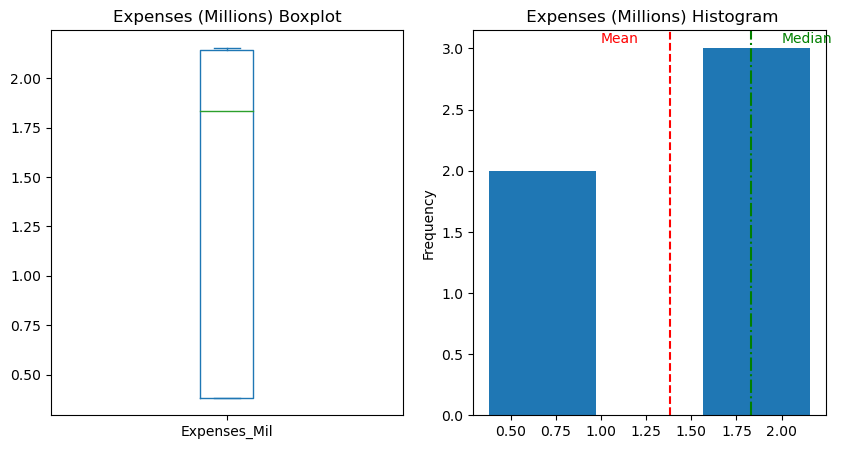

In [7]:
mean = round(df['Expenses_Mil'].mean(),2)
median = round(df['Expenses_Mil'].median(),2)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

df['Expenses_Mil'].plot(kind = 'box', ax = ax[0], title = 'Expenses (Millions) Boxplot')
df['Expenses_Mil'].plot(kind = 'hist', ax = ax[1], title = ' Expenses (Millions) Histogram', bins = 3 )
ax[1].axvline(x = mean, color = 'red', linestyle = '--' ) # <- plotting mean on histogram
ax[1].axvline(x = median, color = 'green', linestyle = '-.') # <- plotting median on histogram
ax[1].text(1,3.05,'Mean', color = 'red')
ax[1].text(2,3.05,'Median', color = 'green')

plt.show()

Based on the histogram, the data is negatively skewed as the median is higher than the mean as it is indicated above. Additonally, there are not outliers in the dataset as indicated in the Boxplot.

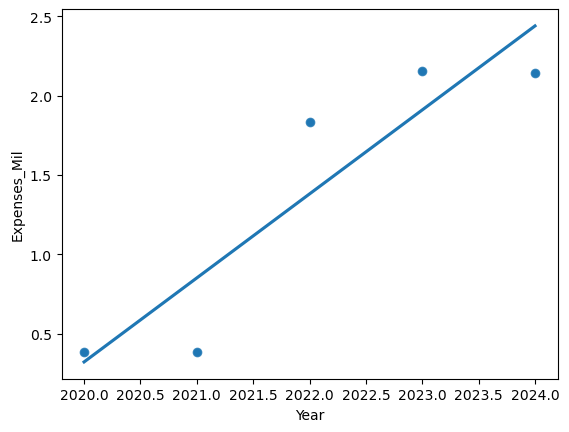

In [8]:
# Plotting Data

sns.scatterplot( x = 'Year', y = 'Expenses_Mil', data = df) # <- scatterplot of FY Health Insurance expenses
sns.regplot( x = 'Year', y = 'Expenses_Mil', ci = None, data = df) # <- Linear Regression

plt.show()

In [9]:
# Creaitng data model
mdl_health_expenses = ols('Expenses_Mil~Year',data = df) # <- Creating model
mdl_health_expenses = mdl_health_expenses.fit() # <- fitting model
print(mdl_health_expenses.params) # <- printing model parameters

Intercept   -1069.137895
Year            0.529435
dtype: float64


In [10]:
# Predicting future data based on the model
explanatory_data = pd.DataFrame({'Year':np.arange(2025,2028)}) # <- creating dataframe with explanatory variable
prediction_data = explanatory_data.assign(Typical = mdl_health_expenses.predict(explanatory_data)) # <- making predictions on explanatory variable

print(prediction_data)

   Year   Typical
0  2025  2.968231
1  2026  3.497666
2  2027  4.027101


In [11]:
# Quantifying model fit
mse = mdl_health_expenses.mse_resid # <- finding mean squared error
rse = np.sqrt(mse) # <- calculating the residual squared error


print('An R-Squared value of',round(mdl_health_expenses.rsquared,2),
      'indicates strong correlation between the explanatory and response varible.',
      'Additonally, there is an rse of',f"${round(rse * mil,2):,}",
      'which is indicative of a typical difference of',f"${round(rse * mil,2):,}",
      'between the predicted and actual values in the model.')

An R-Squared value of 0.83 indicates strong correlation between the explanatory and response varible. Additonally, there is an rse of $438,105.15 which is indicative of a typical difference of $438,105.15 between the predicted and actual values in the model.


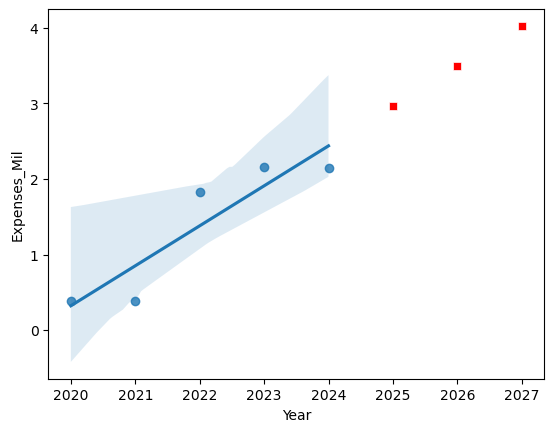

In [12]:
# Visualizing predicted and actual values
sns.scatterplot( x = 'Year', y = 'Typical', data = prediction_data, color = 'red', marker = 's')
sns.regplot( x = 'Year', y = 'Expenses_Mil', data = df) # <- Linear Regression

plt.show()

In [13]:
# Calculating prediction value ranges
prediction_data['Upper Range'] = round((prediction_data['Typical'] + rse) * mil,2)
prediction_data['Lower Range'] = round((prediction_data['Typical'] - rse) * mil,2)
prediction_data['Typical'] = round(prediction_data['Typical'] * mil,2)

prediction_data['Upper Range'] = prediction_data['Upper Range'].apply(lambda x: f'${x:,}')
prediction_data['Lower Range'] = prediction_data['Lower Range'].apply(lambda x: f'${x:,}')
prediction_data['Typical'] = prediction_data['Typical'].apply(lambda x: f'${x:,}')

prediction_data = prediction_data[['Year','Lower Range','Typical','Upper Range']]

print(prediction_data)

   Year    Lower Range        Typical    Upper Range
0  2025  $2,530,125.88  $2,968,231.04  $3,406,336.19
1  2026  $3,059,561.01  $3,497,666.16  $3,935,771.31
2  2027  $3,588,996.13  $4,027,101.28  $4,465,206.44


Based on the predicted values the healthcare expenses for the 2025 fiscal year will fall between the range of \\$2,530,125.88 and \\$3,406,336.19. Based on the projected values the healthcare expenses for the 2026 fiscal year will fall between the range of \\$3,059,561.01 and \\$3,935,771.31. Lastly, based on the projected values the healthcare expenses for the 2027 fiscal year will fall between the range of \\$3,588,996.13 and \\$4,465,206.44